## Feature Engineering with Interaction and Polynomial Features
In this section, we perform feature engineering on the combined dataset by creating interaction features and applying polynomial transformations. These steps help enhance the model's ability to capture complex relationships between variables.

In [3]:
# Importing necessary libraries
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures

### Importing Necessary Libraries
We import Pandas for data manipulation and Scikit-learn's `PolynomialFeatures` for generating polynomial features.

In [4]:
# Load the dataset with outliers handled
data = pd.read_csv('housing_sentiment.csv')

### Loading the Dataset
We load the `combined_data_with_outliers_handled.csv` dataset, which contains the combined monthly and yearly data with outliers handled. This dataset serves as the base for our feature engineering tasks.

In [5]:
# Create interaction features between salary and population, and between population and houses
data['median_salary_population_interaction'] = data['median_salary'] * data['population_size']
data['mean_salary_population_interaction'] = data['mean_salary'] * data['population_size']
data['population_size_houses_interaction'] = data['population_size'] * data['no_of_houses']

### Creating Interaction Features
We create interaction features that capture the multiplicative relationships between key variables:
- `median_salary_population_interaction`: Interaction between median salary and population size.
- `mean_salary_population_interaction`: Interaction between mean salary and population size.
- `population_size_houses_interaction`: Interaction between population size and the number of houses.
These interaction features help capture complex relationships that might not be apparent from the original variables alone.

In [6]:
# Select features for polynomial transformation
poly_features = ['median_salary', 'mean_salary', 'population_size', 'number_of_jobs']

### Selecting Features for Polynomial Transformation
We select a subset of features (`median_salary`, `mean_salary`, `population_size`, and `number_of_jobs`) for polynomial transformation. These features are likely to have nonlinear relationships that can be captured through polynomial expansion.


In [7]:
# Apply polynomial transformation to the selected features
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_transformed = poly.fit_transform(data[poly_features])

### Applying Polynomial Transformation
We apply a polynomial transformation of degree 2 to the selected features. This transformation generates new features representing all possible interactions and squared terms of the selected features, helping the model capture more complex relationships.


In [8]:
# Create a DataFrame for the polynomial features and ensure unique column names
poly_df = pd.DataFrame(poly_transformed, columns=poly.get_feature_names_out(poly_features))
poly_df.columns = [f"poly_{col}" for col in poly_df.columns]

# Merge polynomial features with the original dataset
data = pd.concat([data, poly_df], axis=1)

### Creating and Merging Polynomial Features
We create a DataFrame for the polynomial features, ensuring that the column names are unique and descriptive. These polynomial features are then merged with the original dataset, expanding the feature set for more robust modeling.


## Encoding, PCA and Feature Scaling
In this section, we encode categorical variables, apply Principal Component Analysis (PCA) to reduce dimensionality, and scale the features. These steps prepare the data for modeling.


In [9]:
# Importing necessary libraries
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import pandas as pd

### Importing Necessary Libraries
We import Scikit-learn tools for encoding, scaling, and PCA. Pandas is used for data manipulation.


In [10]:
# Define features and target variable
features = data.drop(columns=['average_price', 'date'])
target = data['average_price']

### Defining Features and Target Variable
We define `features` by excluding the target variable (`average_price`) and the `date` column from the dataset. The `target` variable is set to `average_price`, which we aim to predict.


In [11]:
# Identify categorical and numerical columns
categorical_cols = ['area']
numerical_cols = features.select_dtypes(include=['number']).columns.tolist()

### Identifying Categorical and Numerical Columns
We identify categorical columns (`area`) and numerical columns for further processing. This distinction is important for applying appropriate transformations to each type of feature.


In [12]:
# Define the column transformer with OneHotEncoder for categorical features and SimpleImputer for numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', SimpleImputer(strategy='mean'), numerical_cols)
    ], remainder='passthrough')

# Fit and transform the data
features_encoded = preprocessor.fit_transform(features)

### Encoding Categorical Features and Imputing Missing Values
We use `ColumnTransformer` to apply OneHotEncoder to the categorical column (`area`) and SimpleImputer to fill missing values in numerical columns. This step ensures that categorical variables are properly encoded and numerical variables have no missing values.


In [13]:
# Convert the result to a DataFrame to inspect it
encoded_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
numerical_feature_names = numerical_cols
all_feature_names = list(encoded_feature_names) + numerical_feature_names
features_encoded_df = pd.DataFrame(features_encoded, columns=all_feature_names)

### Inspecting Encoded Features
We convert the encoded features into a DataFrame to inspect the result. This step helps verify that the encoding and imputation have been correctly applied and the feature names are consistent.


In [14]:
# Apply PCA to the encoded categorical features
pca = PCA(n_components=2)  
categorical_pca = pca.fit_transform(features_encoded_df[encoded_feature_names])

# Convert PCA results to a DataFrame
categorical_pca_df = pd.DataFrame(categorical_pca, columns=[f'PCA_{i}' for i in range(categorical_pca.shape[1])])

### Applying PCA to Encoded Categorical Features
We apply Principal Component Analysis (PCA) to the encoded categorical features to reduce dimensionality and capture the most important variance in the data. The result is converted into a DataFrame for easier manipulation.


In [15]:
# Combine PCA results with numerical features
features_combined = pd.concat([categorical_pca_df, features_encoded_df[numerical_feature_names]], axis=1)

### Combining PCA Results with Numerical Features
We combine the PCA-transformed categorical features with the original numerical features to create a comprehensive feature set for modeling.


In [16]:
# Define the StandardScaler for combined features
scaler = StandardScaler()

# Fit and transform the data
features_scaled = scaler.fit_transform(features_combined)

# Convert the result to a DataFrame to inspect it
features_scaled_df = pd.DataFrame(features_scaled, columns=features_combined.columns)

### Scaling the Combined Features
We apply StandardScaler to scale the combined features, ensuring that they are on a similar scale, which is crucial for many machine learning algorithms. The scaled features are then converted into a DataFrame for inspection.


## Train, Validation, and Test Split with Model Training and Evaluation
In this section, we split the dataset into training, validation, and test sets. The models are trained on the training set, evaluated on the validation set, and the performance metrics are recorded.


In [17]:
# Importing necessary libraries
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

### Importing Necessary Libraries
We import Scikit-learn's regression models (Lasso, Ridge, Linear Regression, Random Forest), XGBoost's regressor, and evaluation metrics (MAE, MSE, RMSE, R-squared). We also import `train_test_split` to split the dataset into training, validation, and test sets.


In [18]:
# Splitting the dataset into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(features_scaled_df, target, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

### Splitting the Dataset
We split the dataset into three parts: training set (60%), validation set (20%), and test set (20%). The `train_test_split` function is used twice to achieve this, first to create a temporary set and then to further split it into validation and test sets.


In [19]:
# Define the regression models
models = {
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Lasso Regression': Lasso(random_state=42, max_iter=10000),
    'Ridge Regression': Ridge(random_state=42, max_iter=10000),
    'Multiple Linear Regression': LinearRegression()
}

### Defining the Models
We define a set of regression models to be trained on the training set and evaluated on the validation set. The models include XGBoost, Random Forest, Lasso, Ridge, and Multiple Linear Regression.


In [20]:
# Train and evaluate each model on the validation set
validation_results = {}

for name, model in models.items():
    model.fit(X_train, y_train)  # Train the model
    y_val_pred = model.predict(X_val)  # Predict on the validation set
    
    # Calculate evaluation metrics on the validation set
    mae = mean_absolute_error(y_val, y_val_pred)
    mse = mean_squared_error(y_val, y_val_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val, y_val_pred)
    
    # Store the results
    validation_results[name] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R-squared': r2}

/Users/phyuphyuaung/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.084e+11, tolerance: 1.078e+09
  model = cd_fast.enet_coordinate_descent(


### Training and Evaluating on the Validation Set
We train each model on the training set and evaluate its performance on the validation set using key metrics: MAE, MSE, RMSE, and R-squared. These metrics help assess how well the models generalize to unseen data.


In [21]:
# Convert the validation results to a DataFrame for easy comparison
validation_results_df = pd.DataFrame(validation_results).T

# Display the validation results
validation_results_df

,MAE,MSE,RMSE,R-squared
XGBoost,30997.504175,2.067318e+09,45467.766513,0.903007
Random Forest,31556.058154,2.073510e+09,45535.810964,0.902716
Lasso Regression,53646.510629,5.482123e+09,74041.361471,0.742793
Ridge Regression,52344.655907,5.326668e+09,72984.025878,0.750087
Multiple Linear Regression,53569.196561,5.450563e+09,73827.925215,0.744274


### Displaying the Validation Results
We convert the validation results into a DataFrame to facilitate comparison across different models and metrics. The DataFrame is displayed to summarize the performance of the models on the validation set.


## Checking for Overfitting
In this section, we compare the performance of models on the training set (using cross-validation) and the validation set to identify potential overfitting. Overfitting occurs when a model performs significantly better on the training data than on unseen validation data.

In [22]:
# Importing necessary libraries
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd

### Importing Necessary Libraries
We import Scikit-learn tools for model training, evaluation, and cross-validation, along with XGBoost's regressor. Additionally, NumPy and Pandas are imported for numerical operations and organizing results.


In [23]:
# Define the regression models
models = {
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Lasso Regression': Lasso(random_state=42),
    'Ridge Regression': Ridge(random_state=42),
    'Multiple Linear Regression': LinearRegression()
}

### Defining the Models
We define a set of regression models, including XGBoost, Random Forest, Lasso, Ridge, and Multiple Linear Regression, to be evaluated for potential overfitting.


In [24]:
# Define custom scoring functions for evaluation
scoring = {
    'MAE': make_scorer(mean_absolute_error),
    'MSE': make_scorer(mean_squared_error),
    'RMSE': make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))),
    'R-squared': make_scorer(r2_score)
}

### Defining Custom Scoring Functions
We define custom scoring functions to evaluate the models based on Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R-squared. These metrics provide a comprehensive evaluation of model performance.


In [25]:
# Perform cross-validation on the training set and collect results
cv_results = {}

for name, model in models.items():
    scores = {metric: cross_val_score(model, X_train, y_train, cv=5, scoring=scoring[metric]).mean() for metric in scoring}
    cv_results[name] = scores

/Users/phyuphyuaung/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.451e+11, tolerance: 8.556e+08
  model = cd_fast.enet_coordinate_descent(
/Users/phyuphyuaung/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.913e+11, tolerance: 8.989e+08
  model = cd_fast.enet_coordinate_descent(
/Users/phyuphyuaung/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 

### Performing Cross-Validation on the Training Set
We perform 5-fold cross-validation on the training set for each model, calculating the mean score for each metric (MAE, MSE, RMSE, R-squared). These cross-validation results provide insights into the model's performance during training.


In [26]:
# Convert the cross-validation results to a DataFrame for easy comparison
cv_results_df = pd.DataFrame(cv_results).T

# Display the cross-validation results
cv_results_df

,MAE,MSE,RMSE,R-squared
XGBoost,31982.944799,2.293261e+09,47747.601195,0.910915
Random Forest,37725.706767,2.757743e+09,52470.053475,0.891863
Lasso Regression,54375.622721,5.186776e+09,71853.473573,0.791828
Ridge Regression,54039.314663,5.166421e+09,71726.854731,0.792836
Multiple Linear Regression,54460.766104,5.219175e+09,72087.651391,0.790629


### Displaying the Cross-Validation Results
We convert the cross-validation results into a DataFrame to facilitate comparison across different models and metrics. The DataFrame is displayed to summarize the performance of the models during cross-validation on the training set.


In [27]:
# Evaluate models on the validation set
validation_results = {}

for name, model in models.items():
    model.fit(X_train, y_train)  # Train the model on the training data
    y_val_pred = model.predict(X_val)  # Predict on the validation set
    
    # Calculate evaluation metrics on the validation set
    validation_scores = {
        'MAE': mean_absolute_error(y_val, y_val_pred),
        'MSE': mean_squared_error(y_val, y_val_pred),
        'RMSE': np.sqrt(mean_squared_error(y_val, y_val_pred)),
        'R-squared': r2_score(y_val, y_val_pred)
    }
    validation_results[name] = validation_scores

/Users/phyuphyuaung/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.990e+11, tolerance: 1.078e+09
  model = cd_fast.enet_coordinate_descent(


### Evaluating Models on the Validation Set
We evaluate the trained models on the validation set to calculate performance metrics (MAE, MSE, RMSE, R-squared). These validation results provide an understanding of how well the models generalize to unseen data.


In [28]:
# Convert the validation results to a DataFrame for easy comparison
validation_results_df = pd.DataFrame(validation_results).T

# Display the validation results
validation_results_df

,MAE,MSE,RMSE,R-squared
XGBoost,30997.504175,2.067318e+09,45467.766513,0.903007
Random Forest,31556.058154,2.073510e+09,45535.810964,0.902716
Lasso Regression,53586.132139,5.521153e+09,74304.458641,0.740962
Ridge Regression,52344.655907,5.326668e+09,72984.025878,0.750087
Multiple Linear Regression,53569.196561,5.450563e+09,73827.925215,0.744274


### Displaying the Validation Results
We convert the validation results into a DataFrame to facilitate comparison across different models and metrics. The DataFrame is displayed to summarize the performance of the models on the validation set.


In [29]:
# Compare cross-validation results with validation results to check for overfitting
comparison_df = pd.concat([cv_results_df, validation_results_df], axis=1, keys=['Cross-Validation', 'Validation'])

# Display the comparison
comparison_df


Cross-Validation                              \
                                        MAE           MSE          RMSE   
XGBoost                        31982.944799  2.293261e+09  47747.601195   
Random Forest                  37725.706767  2.757743e+09  52470.053475   
Lasso Regression               54375.622721  5.186776e+09  71853.473573   
Ridge Regression               54039.314663  5.166421e+09  71726.854731   
Multiple Linear Regression     54460.766104  5.219175e+09  72087.651391   

                                        Validation                \
                           R-squared           MAE           MSE   
XGBoost                     0.910915  30997.504175  2.067318e+09   
Random Forest               0.891863  31556.058154  2.073510e+09   
Lasso Regression            0.791828  53586.132139  5.521153e+09   
Ridge Regression            0.792836  52344.655907  5.326668e+09   
Multiple Linear Regression  0.790629  53569.196561  5.450563e+09   

                                                    
                                    RMSE R-squared  
XGBoost                     45467.766513  0.903007  
Random Forest               45535.810964  0.902716  
Lasso Regression            74304.458641  0.740962  
Ridge Regression            72984.025878  0.750087  
Multiple Linear Regression  73827.925215  0.744274

### Comparing Cross-Validation and Validation Results
We concatenate the cross-validation results and validation results into a single DataFrame to compare them side by side. This comparison helps identify overfitting by revealing if a model performs significantly better on the training data than on the validation data.


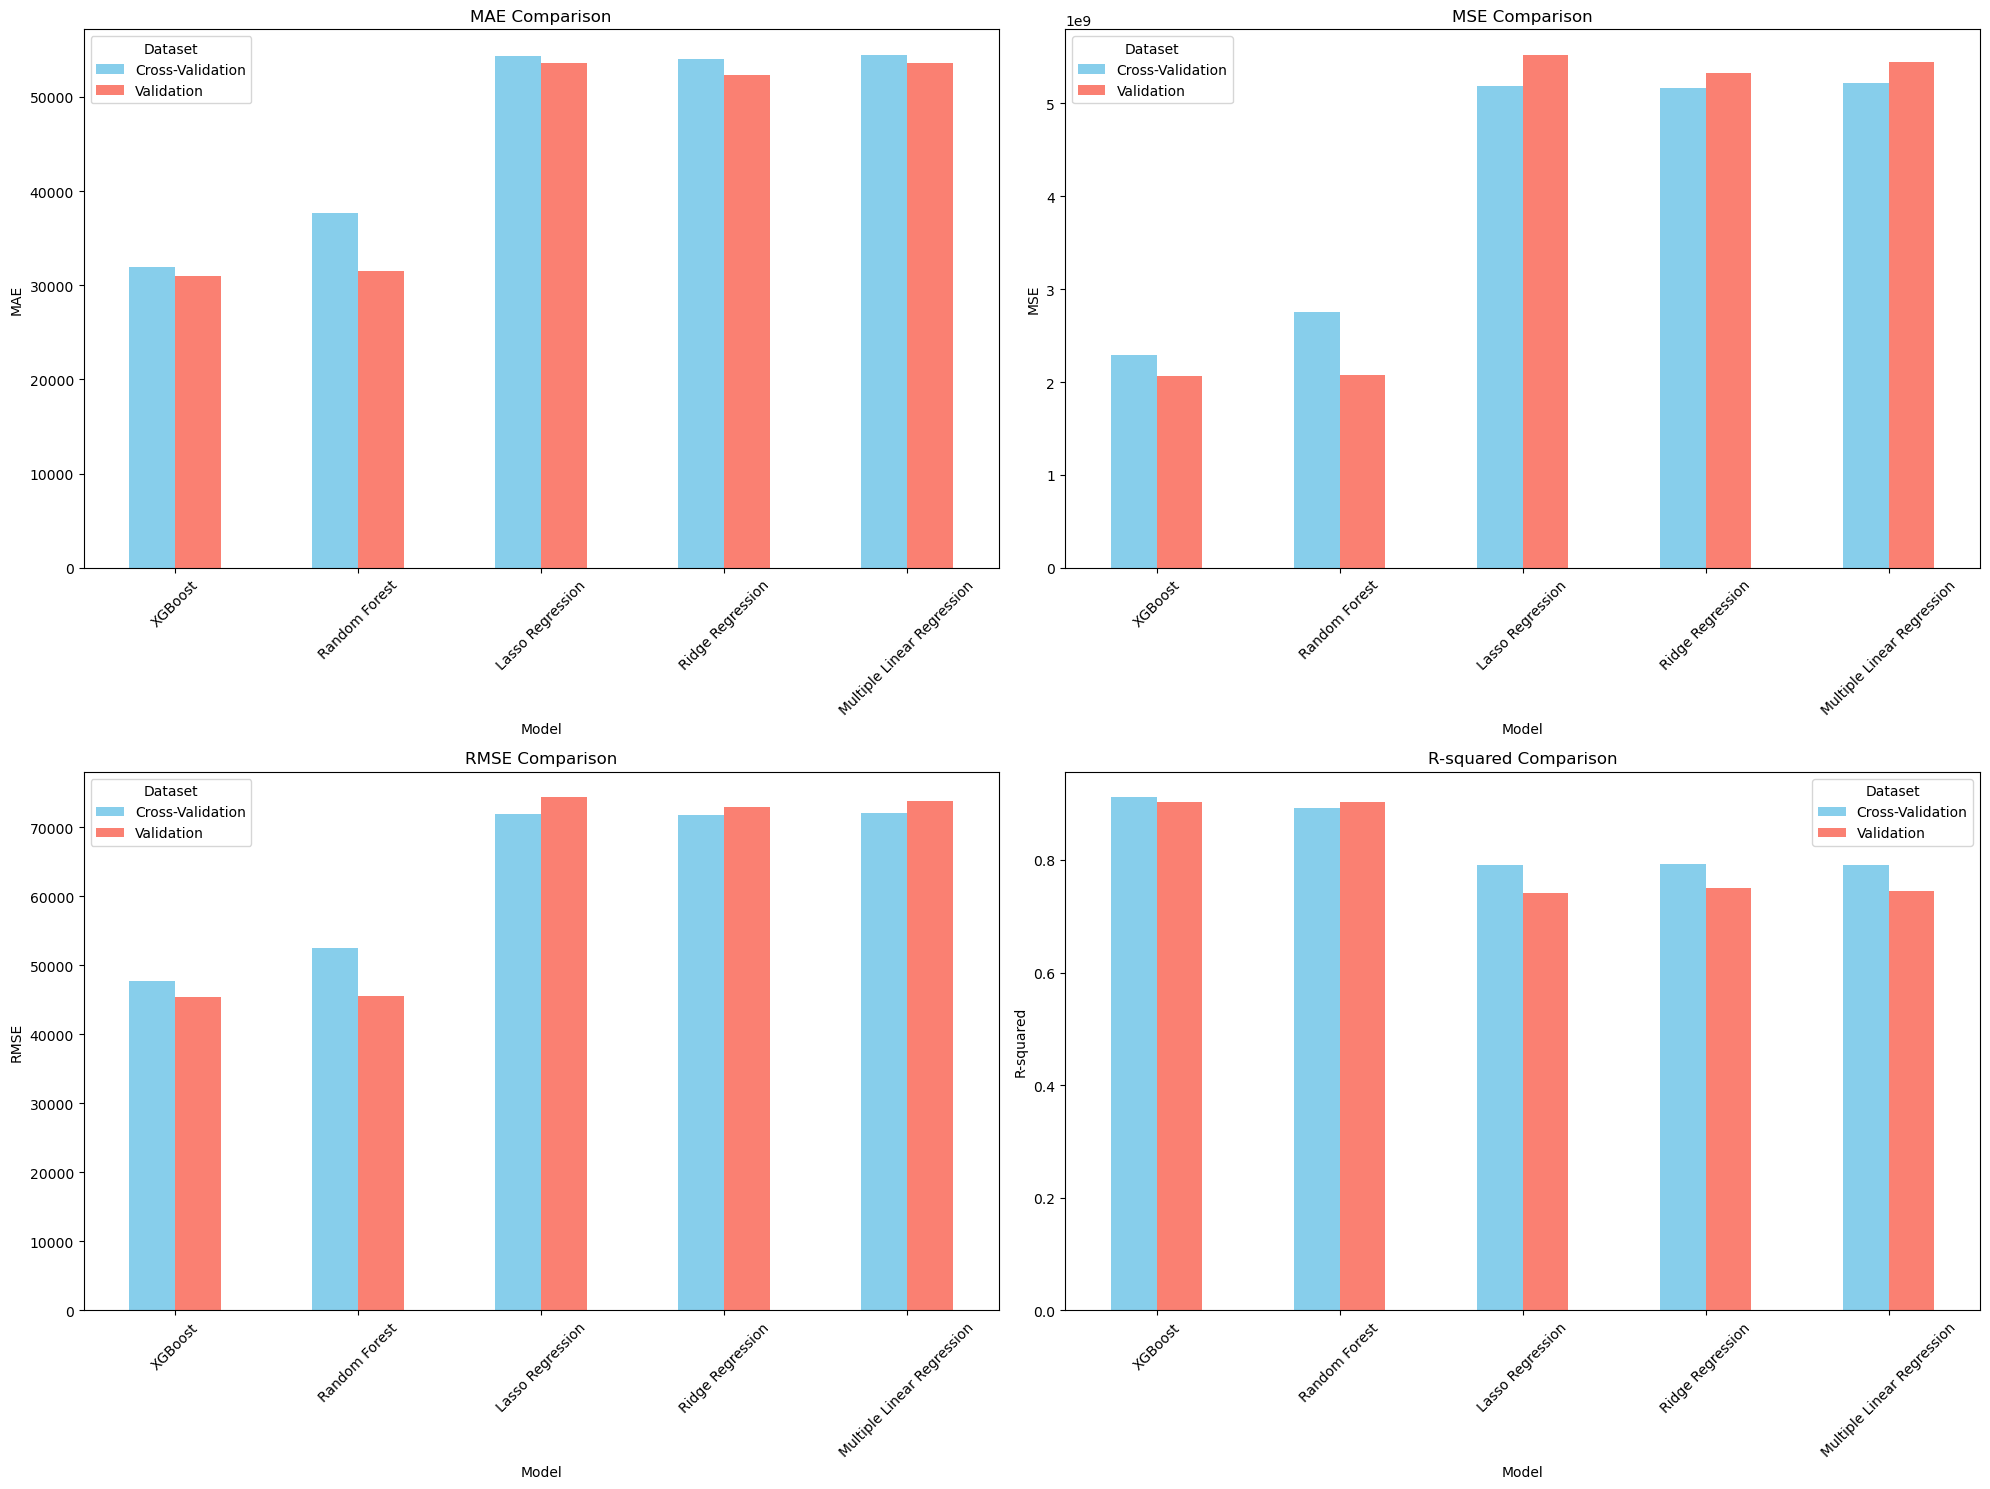

In [30]:
import matplotlib.pyplot as plt

# Define a function to plot model performance
def plot_model_performance(comparison_df):
    metrics = ['MAE', 'MSE', 'RMSE', 'R-squared']
    
    plt.figure(figsize=(20, 15))
    
    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)
        comparison_df.xs(metric, axis=1, level=1).plot(kind='bar', ax=plt.gca(), color=['skyblue', 'salmon'])
        plt.title(f'{metric} Comparison')
        plt.ylabel(metric)
        plt.xlabel('Model')
        plt.xticks(rotation=45)
        plt.legend(title='Dataset')
    
    plt.tight_layout()
    plt.show()

# Plot the model performance
plot_model_performance(comparison_df)


## Hyperparameter Tuning for All Models
In this section, we perform hyperparameter tuning using `GridSearchCV` for each model based on the specified parameter grids.


In [31]:
# Import necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import pandas as pd

### Importing Necessary Libraries
We import `GridSearchCV` for hyperparameter tuning, as well as the necessary model classes (`Lasso`, `Ridge`, `LinearRegression`, `RandomForestRegressor`, `XGBRegressor`) for the models.


In [32]:
# Define parameter grids for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [1, 3, 5, 7],
    'reg_alpha': [0, 0.1, 1, 2],
    'reg_lambda': [0, 1, 5, 10],
    'min_child_weight': [1, 5, 10]
}

# Define parameter grids for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Define the parameter grid for Lasso
param_grid_lasso = {
    'alpha': [0.01, 0.1, 1, 10, 100, 200, 300]
}

# Define the parameter grid for Ridge
param_grid_ridge = {
    'alpha': [0.01, 0.1, 1, 10, 100]
}

# Define the parameter grid for Multiple Linear Regression
param_grid_linear = {
    'fit_intercept': [True, False]
}

### Defining Parameter Grids
We define the parameter grids for XGBoost, Random Forest, Lasso, Ridge, and Multiple Linear Regression models. These grids will be used to perform hyperparameter tuning using `GridSearchCV`.


In [33]:
# Initialize the models
xgb = XGBRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)
lasso = Lasso(random_state=42)
ridge = Ridge(random_state=42)
linear = LinearRegression()

### Initializing Models
We initialize the models that will be tuned using the defined parameter grids.


In [34]:
# Perform GridSearchCV for each model
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search_lasso = GridSearchCV(estimator=lasso, param_grid=param_grid_lasso, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search_ridge = GridSearchCV(estimator=ridge, param_grid=param_grid_ridge, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search_linear = GridSearchCV(estimator=linear, param_grid=param_grid_linear, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

# Fit the models
grid_search_xgb.fit(X_train, y_train)
grid_search_rf.fit(X_train, y_train)
grid_search_lasso.fit(X_train, y_train)
grid_search_ridge.fit(X_train, y_train)
grid_search_linear.fit(X_train, y_train)

/Users/phyuphyuaung/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.317e+11, tolerance: 8.989e+08
  model = cd_fast.enet_coordinate_descent(
/Users/phyuphyuaung/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.737e+11, tolerance: 8.556e+08
  model = cd_fast.enet_coordinate_descent(
/Users/phyuphyuaung/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 

GridSearchCV(cv=5, estimator=LinearRegression(), n_jobs=-1,
             param_grid={'fit_intercept': [True, False]},
             scoring='neg_mean_absolute_error')

### Running GridSearchCV for Each Model
We set up `GridSearchCV` for each model using the specified parameter grids and 5-fold cross-validation. The scoring metric used is `neg_mean_absolute_error`, and all available processors are used for computation (`n_jobs=-1`).


In [35]:
# Extract the best parameters for each model
best_params = {
    'XGBoost': grid_search_xgb.best_params_,
    'Random Forest': grid_search_rf.best_params_,
    'Lasso Regression': grid_search_lasso.best_params_,
    'Ridge Regression': grid_search_ridge.best_params_,
    'Multiple Linear Regression': grid_search_linear.best_params_
}

# Convert the best parameters to a DataFrame for easy inspection
best_params_df = pd.DataFrame.from_dict(best_params, orient='index')

# Display the best parameters
best_params_df

,learning_rate,max_depth,min_child_weight,n_estimators,reg_alpha,reg_lambda,min_samples_leaf,min_samples_split,alpha,fit_intercept
XGBoost,0.1,3.0,1.0,400.0,0.0,10.0,NaN,NaN,NaN,NaN
Random Forest,NaN,20.0,NaN,300.0,NaN,NaN,1.0,2.0,NaN,NaN
Lasso Regression,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN
Ridge Regression,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
Multiple Linear Regression,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


### Extracting and Displaying Best Parameters
We extract the best parameters for each model after running `GridSearchCV` and store them in a dictionary. This dictionary is then converted into a DataFrame for easy inspection and display.


## Evaluation on Validation Set for All Models
In this section, we evaluate the best models obtained from hyperparameter tuning on the validation set. We will calculate and display performance metrics such as MAE, MSE, RMSE, and R-squared.


In [36]:
# Import necessary libraries for evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

### Importing Necessary Libraries
We import Scikit-learn's evaluation metrics (`mean_absolute_error`, `mean_squared_error`, `r2_score`) and use NumPy for numerical operations. Pandas is used to organize the results.


In [37]:
# Extract the best models from the GridSearchCV results
best_xgb = grid_search_xgb.best_estimator_
best_rf = grid_search_rf.best_estimator_
best_lasso = grid_search_lasso.best_estimator_
best_ridge = grid_search_ridge.best_estimator_
best_linear = grid_search_linear.best_estimator_

### Extracting Best Models
We extract the best models from the GridSearchCV results. These models have been trained with the best hyperparameters identified during the tuning process.


In [38]:
# Predict on the validation set using the best models
y_pred_xgb = best_xgb.predict(X_val)
y_pred_rf = best_rf.predict(X_val)
y_pred_lasso = best_lasso.predict(X_val)
y_pred_ridge = best_ridge.predict(X_val)
y_pred_linear = best_linear.predict(X_val)

### Predicting on the Validation Set
We use the best models to make predictions on the validation set. These predictions will be used to evaluate the performance of each model.


In [39]:
# Calculate performance metrics for each model on the validation set

# XGBoost
mae_xgb = mean_absolute_error(y_val, y_pred_xgb)
mse_xgb = mean_squared_error(y_val, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_val, y_pred_xgb)

# Random Forest
mae_rf = mean_absolute_error(y_val, y_pred_rf)
mse_rf = mean_squared_error(y_val, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_val, y_pred_rf)

# Lasso Regression
mae_lasso = mean_absolute_error(y_val, y_pred_lasso)
mse_lasso = mean_squared_error(y_val, y_pred_lasso)
rmse_lasso = np.sqrt(mse_lasso)
r2_lasso = r2_score(y_val, y_pred_lasso)

# Ridge Regression
mae_ridge = mean_absolute_error(y_val, y_pred_ridge)
mse_ridge = mean_squared_error(y_val, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)
r2_ridge = r2_score(y_val, y_pred_ridge)

# Multiple Linear Regression
mae_linear = mean_absolute_error(y_val, y_pred_linear)
mse_linear = mean_squared_error(y_val, y_pred_linear)
rmse_linear = np.sqrt(mse_linear)
r2_linear = r2_score(y_val, y_pred_linear)

### Calculating Performance Metrics
We calculate key performance metrics (MAE, MSE, RMSE, R-squared) for each model on the validation set. These metrics provide insights into how well each model generalizes to unseen data.


In [40]:
# Compile the evaluation results into a dictionary
evaluation_results = {
    'XGBoost': {'MAE': mae_xgb, 'MSE': mse_xgb, 'RMSE': rmse_xgb, 'R-squared': r2_xgb},
    'Random Forest': {'MAE': mae_rf, 'MSE': mse_rf, 'RMSE': rmse_rf, 'R-squared': r2_rf},
    'Lasso Regression': {'MAE': mae_lasso, 'MSE': mse_lasso, 'RMSE': rmse_lasso, 'R-squared': r2_lasso},
    'Ridge Regression': {'MAE': mae_ridge, 'MSE': mse_ridge, 'RMSE': rmse_ridge, 'R-squared': r2_ridge},
    'Multiple Linear Regression': {'MAE': mae_linear, 'MSE': mse_linear, 'RMSE': rmse_linear, 'R-squared': r2_linear}
}

# Convert the results into a DataFrame for easy inspection
evaluation_results_df = pd.DataFrame(evaluation_results).T

# Display the evaluation results
evaluation_results_df

,MAE,MSE,RMSE,R-squared
XGBoost,22804.010167,1.217731e+09,34896.002536,0.942867
Random Forest,31875.777743,2.113485e+09,45972.658624,0.900841
Lasso Regression,52169.454450,5.346416e+09,73119.191776,0.749160
Ridge Regression,52344.655907,5.326668e+09,72984.025878,0.750087
Multiple Linear Regression,53569.196561,5.450563e+09,73827.925215,0.744274


### Compiling and Displaying Evaluation Results
We compile the evaluation results into a dictionary and convert it into a DataFrame for easy inspection. The DataFrame is then displayed, summarizing the performance of each model on the validation set.



## Checking for Overfitting After Hyperparameter Tuning
In this section, we compare the cross-validation results on the training set with the performance on the validation set to check for overfitting in the tuned models.


In [41]:
# Import necessary libraries for evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

### Importing Necessary Libraries
We import Scikit-learn's evaluation metrics (MAE, MSE, RMSE, R-squared) and use NumPy and Pandas for numerical operations and organizing results.


In [42]:
# Predict on the validation set using the best models
y_pred_xgb = best_xgb.predict(X_val)
y_pred_rf = best_rf.predict(X_val)
y_pred_lasso = best_lasso.predict(X_val)
y_pred_ridge = best_ridge.predict(X_val)
y_pred_linear = best_linear.predict(X_val)

# Calculate performance metrics for each model on the validation set

# XGBoost
mae_xgb_val = mean_absolute_error(y_val, y_pred_xgb)
mse_xgb_val = mean_squared_error(y_val, y_pred_xgb)
rmse_xgb_val = np.sqrt(mse_xgb_val)
r2_xgb_val = r2_score(y_val, y_pred_xgb)

# Random Forest
mae_rf_val = mean_absolute_error(y_val, y_pred_rf)
mse_rf_val = mean_squared_error(y_val, y_pred_rf)
rmse_rf_val = np.sqrt(mse_rf_val)
r2_rf_val = r2_score(y_val, y_pred_rf)

# Lasso Regression
mae_lasso_val = mean_absolute_error(y_val, y_pred_lasso)
mse_lasso_val = mean_squared_error(y_val, y_pred_lasso)
rmse_lasso_val = np.sqrt(mse_lasso_val)
r2_lasso_val = r2_score(y_val, y_pred_lasso)

# Ridge Regression
mae_ridge_val = mean_absolute_error(y_val, y_pred_ridge)
mse_ridge_val = mean_squared_error(y_val, y_pred_ridge)
rmse_ridge_val = np.sqrt(mse_ridge_val)
r2_ridge_val = r2_score(y_val, y_pred_ridge)

# Multiple Linear Regression
mae_linear_val = mean_absolute_error(y_val, y_pred_linear)
mse_linear_val = mean_squared_error(y_val, y_pred_linear)
rmse_linear_val = np.sqrt(mse_linear_val)
r2_linear_val = r2_score(y_val, y_pred_linear)

### Evaluating Tuned Models on the Validation Set
We use the best models to predict on the validation set and calculate performance metrics (MAE, MSE, RMSE, R-squared) for each model. These metrics will be compared with cross-validation results to check for overfitting.


In [43]:
# Summarize the cross-validation results for the tuned models
tuned_cv_summary = {}
for model_name, results in cv_results.items():
    tuned_cv_summary[model_name] = {
        'Mean MAE (CV)': -np.mean(results['MAE']),
        'Mean MSE (CV)': -np.mean(results['MSE']),
        'Mean RMSE (CV)': -np.mean(results['RMSE']),
        'Mean R-squared (CV)': np.mean(results['R-squared'])
    }

# Summarize the validation set results
validation_summary = {
    'XGBoost': {'MAE (Val)': mae_xgb_val, 'MSE (Val)': mse_xgb_val, 'RMSE (Val)': rmse_xgb_val, 'R-squared (Val)': r2_xgb_val},
    'Random Forest': {'MAE (Val)': mae_rf_val, 'MSE (Val)': mse_rf_val, 'RMSE (Val)': rmse_rf_val, 'R-squared (Val)': r2_rf_val},
    'Lasso Regression': {'MAE (Val)': mae_lasso_val, 'MSE (Val)': mse_lasso_val, 'RMSE (Val)': rmse_lasso_val, 'R-squared (Val)': r2_lasso_val},
    'Ridge Regression': {'MAE (Val)': mae_ridge_val, 'MSE (Val)': mse_ridge_val, 'RMSE (Val)': rmse_ridge_val, 'R-squared (Val)': r2_ridge_val},
    'Multiple Linear Regression': {'MAE (Val)': mae_linear_val, 'MSE (Val)': mse_linear_val, 'RMSE (Val)': rmse_linear_val, 'R-squared (Val)': r2_linear_val}
}

# Convert the summaries into DataFrames for comparison
tuned_cv_df = pd.DataFrame(tuned_cv_summary).T
validation_df = pd.DataFrame(validation_summary).T

# Combine the cross-validation and validation results
comparison_df1 = pd.concat([tuned_cv_df, validation_df], axis=1)

# Display the comparison
comparison_df1


,Mean MAE (CV),Mean MSE (CV),Mean RMSE (CV),Mean R-squared (CV),MAE (Val),MSE (Val),RMSE (Val),R-squared (Val)
XGBoost,-31982.944799,-2.293261e+09,-47747.601195,0.910915,22804.010167,1.217731e+09,34896.002536,0.942867
Random Forest,-37725.706767,-2.757743e+09,-52470.053475,0.891863,31875.777743,2.113485e+09,45972.658624,0.900841
Lasso Regression,-54375.622721,-5.186776e+09,-71853.473573,0.791828,52169.454450,5.346416e+09,73119.191776,0.749160
Ridge Regression,-54039.314663,-5.166421e+09,-71726.854731,0.792836,52344.655907,5.326668e+09,72984.025878,0.750087
Multiple Linear Regression,-54460.766104,-5.219175e+09,-72087.651391,0.790629,53569.196561,5.450563e+09,73827.925215,0.744274


In [44]:
import pandas as pd

# Assuming comparison_df1 is your DataFrame

# Convert all cross-validation metrics to positive numbers
comparison_df1['Mean MAE (CV)'] = comparison_df1['Mean MAE (CV)'].abs()
comparison_df1['Mean MSE (CV)'] = comparison_df1['Mean MSE (CV)'].apply(pd.to_numeric).abs()
comparison_df1['Mean RMSE (CV)'] = comparison_df1['Mean RMSE (CV)'].abs()

# Convert validation metrics to positive numbers
comparison_df1['MAE (Val)'] = comparison_df1['MAE (Val)'].abs()
comparison_df1['MSE (Val)'] = comparison_df1['MSE (Val)'].apply(pd.to_numeric).abs()
comparison_df1['RMSE (Val)'] = comparison_df1['RMSE (Val)'].abs()

# Convert MSE columns to integer type
comparison_df1['Mean MSE (CV)'] = comparison_df1['Mean MSE (CV)'].astype(int)
comparison_df1['MSE (Val)'] = comparison_df1['MSE (Val)'].astype(int)

# Display the updated DataFrame
comparison_df1


,Mean MAE (CV),Mean MSE (CV),Mean RMSE (CV),Mean R-squared (CV),MAE (Val),MSE (Val),RMSE (Val),R-squared (Val)
XGBoost,31982.944799,2293261004,47747.601195,0.910915,22804.010167,1217730993,34896.002536,0.942867
Random Forest,37725.706767,2757742572,52470.053475,0.891863,31875.777743,2113485340,45972.658624,0.900841
Lasso Regression,54375.622721,5186776215,71853.473573,0.791828,52169.454450,5346416205,73119.191776,0.749160
Ridge Regression,54039.314663,5166421096,71726.854731,0.792836,52344.655907,5326668033,72984.025878,0.750087
Multiple Linear Regression,54460.766104,5219174812,72087.651391,0.790629,53569.196561,5450562541,73827.925215,0.744274


convert all relevant metrics in the DataFrame to positive numbers and convert the MSE columns to integers.

### Comparing Cross-Validation and Validation Results
We compare the mean cross-validation metrics with the validation set metrics for each tuned model. A significant difference between these metrics may indicate overfitting.


In [45]:
print(comparison_df1.columns)


Index(['Mean MAE (CV)', 'Mean MSE (CV)', 'Mean RMSE (CV)',
       'Mean R-squared (CV)', 'MAE (Val)', 'MSE (Val)', 'RMSE (Val)',
       'R-squared (Val)'],
      dtype='object')


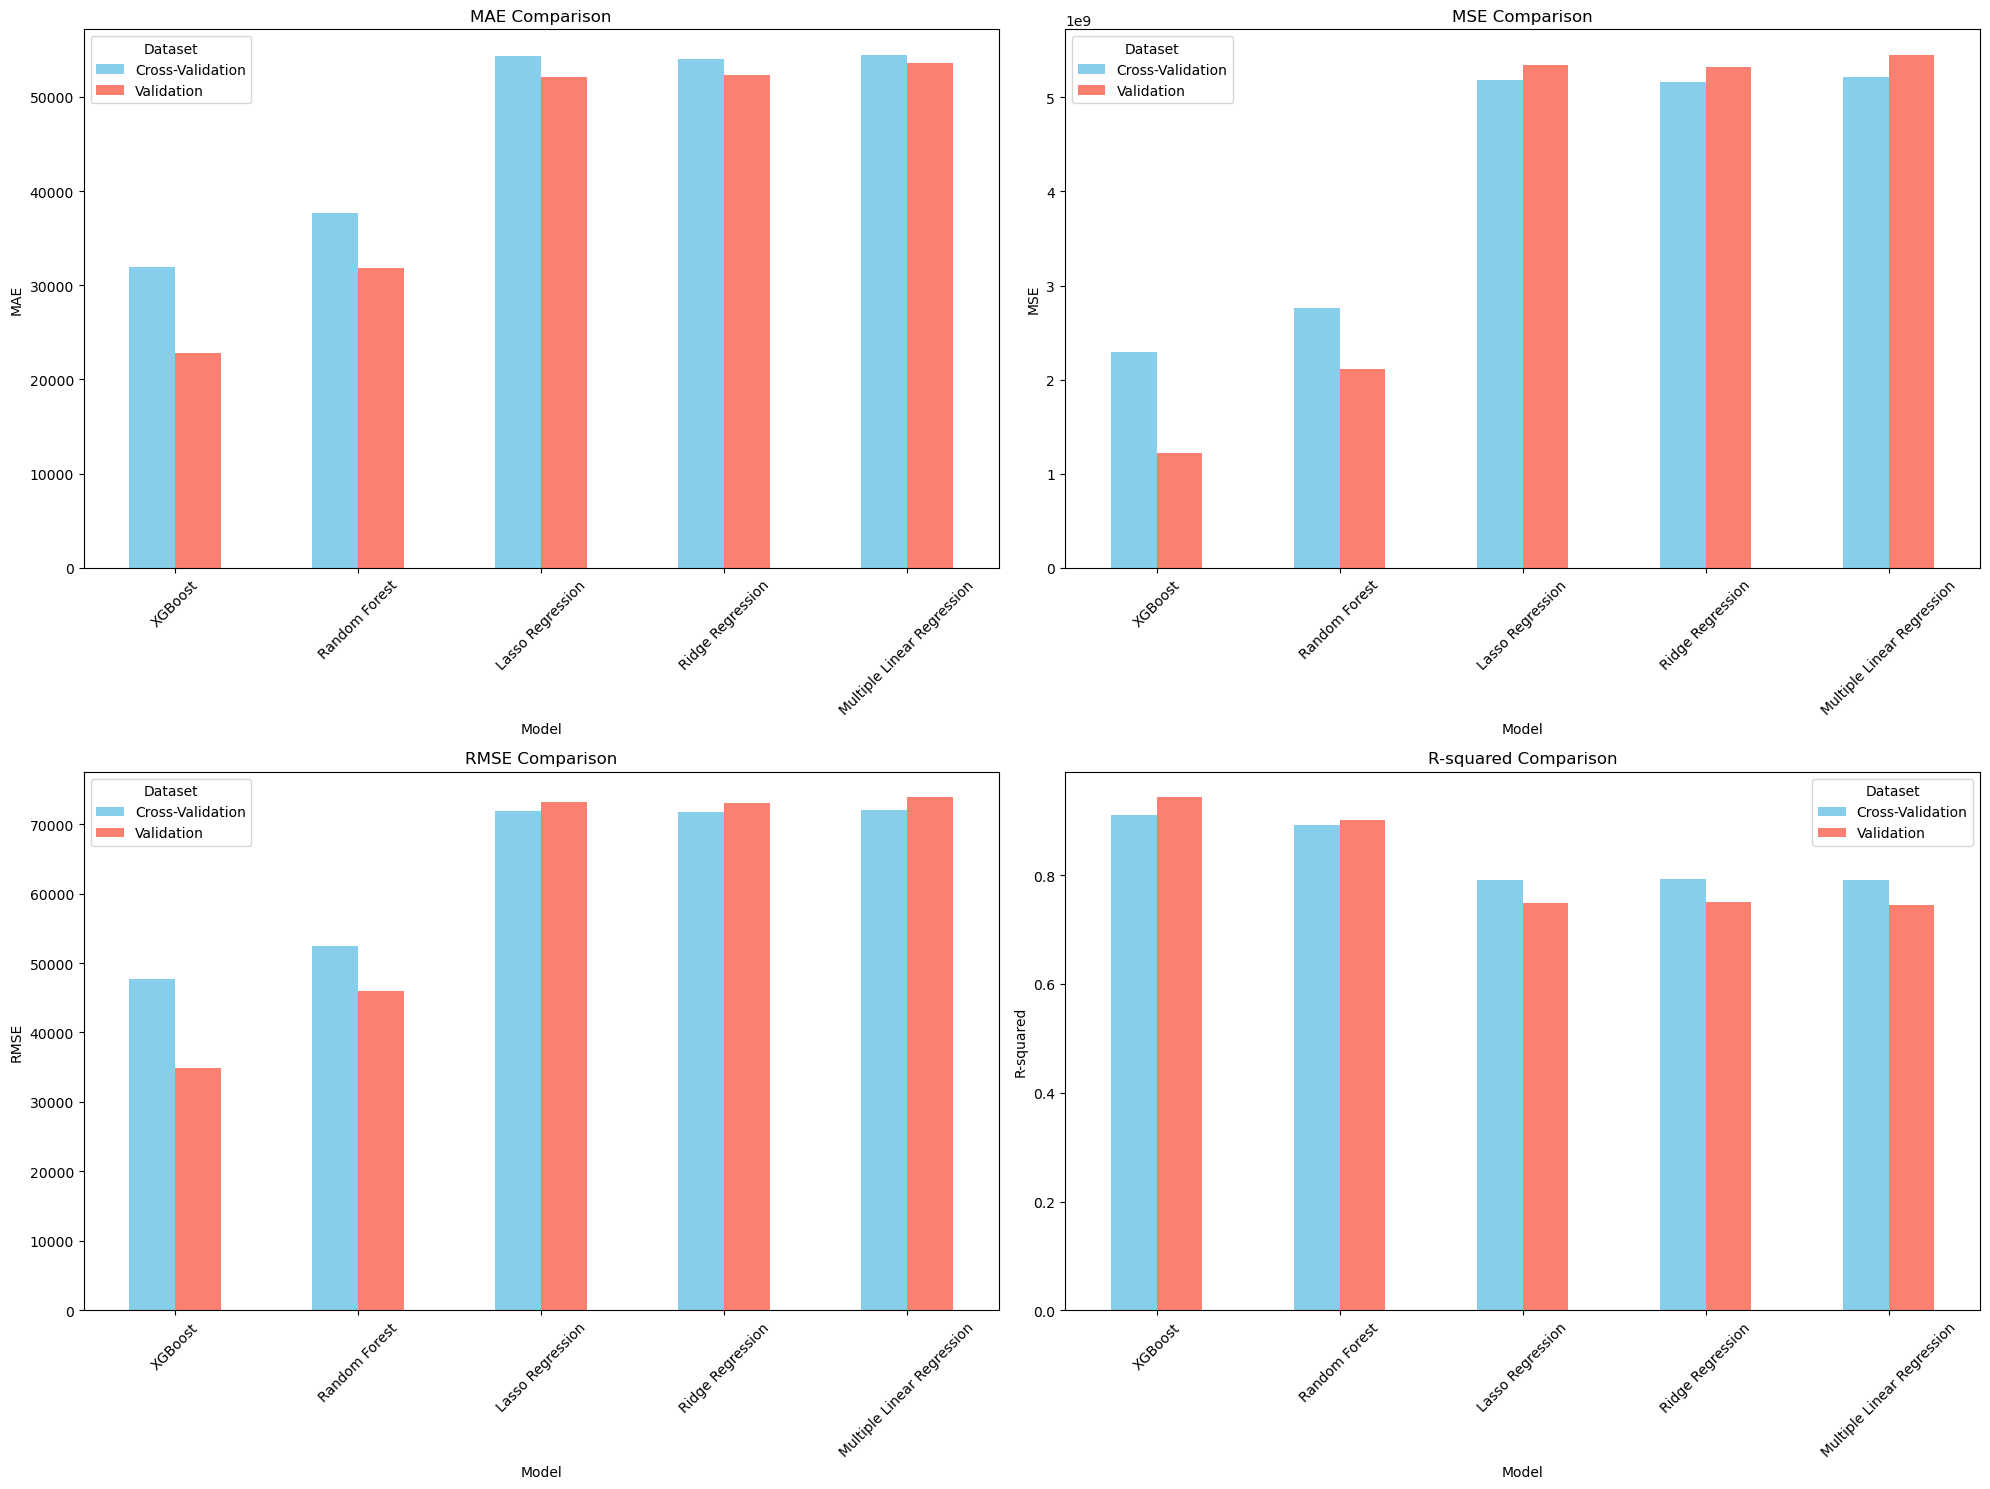

In [46]:
import matplotlib.pyplot as plt

# Define a function to plot model performance
def plot_model_performance(comparison_df1):
    metrics = {
        'MAE': ['Mean MAE (CV)', 'MAE (Val)'],
        'MSE': ['Mean MSE (CV)', 'MSE (Val)'],
        'RMSE': ['Mean RMSE (CV)', 'RMSE (Val)'],
        'R-squared': ['Mean R-squared (CV)', 'R-squared (Val)']
    }
    
    plt.figure(figsize=(20, 15))
    
    for i, (metric, columns) in enumerate(metrics.items(), 1):
        plt.subplot(2, 2, i)
        comparison_df1[columns].plot(kind='bar', ax=plt.gca(), color=['skyblue', 'salmon'])
        plt.title(f'{metric} Comparison')
        plt.ylabel(metric)
        plt.xlabel('Model')
        plt.xticks(rotation=45)
        plt.legend(['Cross-Validation', 'Validation'], title='Dataset')
    
    plt.tight_layout()
    plt.show()

# Plot the model performance comparison
plot_model_performance(comparison_df1)


## Ensemble of XGBoost and Random Forest
In this section, we create an ensemble model by averaging the predictions of XGBoost and Random Forest. The ensemble is then evaluated on the validation set to assess its performance.


In [47]:
# Import necessary libraries
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Importing Necessary Libraries
We import NumPy for numerical operations and Scikit-learn's metrics (MAE, MSE, RMSE, R-squared) for evaluating the ensemble model.


In [48]:
# Predict on the validation set using XGBoost and Random Forest
y_pred_xgb = best_xgb.predict(X_val)
y_pred_rf = best_rf.predict(X_val)

### Making Predictions with XGBoost and Random Forest
We use the best models obtained from hyperparameter tuning to make predictions on the validation set.


In [49]:
# Ensemble by averaging the predictions of XGBoost and Random Forest
y_pred_ensemble = (y_pred_xgb + y_pred_rf) / 2

### Averaging the Predictions
We create the ensemble by averaging the predictions from XGBoost and Random Forest. This simple approach combines the strengths of both models.


In [50]:
# Calculate performance metrics for the ensemble model
mae_ensemble = mean_absolute_error(y_val, y_pred_ensemble)
mse_ensemble = mean_squared_error(y_val, y_pred_ensemble)
rmse_ensemble = np.sqrt(mse_ensemble)
r2_ensemble = r2_score(y_val, y_pred_ensemble)

# Compile the results into a dictionary
ensemble_results = {
    'Ensemble Model': {'MAE': mae_ensemble, 'MSE': mse_ensemble, 'RMSE': rmse_ensemble, 'R-squared': r2_ensemble}
}

# Convert the results into a DataFrame for easy comparison
ensemble_results_df = pd.DataFrame(ensemble_results).T

# Convert MSE columns to integer type
ensemble_results_df['MSE'] = ensemble_results_df['MSE'].astype(int)
ensemble_results_df['MSE'] = ensemble_results_df['MSE'].astype(int)

# Display the ensemble model's performance
ensemble_results_df

,MAE,MSE,R-squared,RMSE
Ensemble Model,26040.182788,1503032421,0.929482,38768.962087


### Evaluating the Ensemble Model
We evaluate the performance of the ensemble model using key metrics (MAE, MSE, RMSE, R-squared) on the validation set. The results provide insights into how well the ensemble model performs compared to the individual models.


## Stacking Ensemble of XGBoost and Random Forest
In this section, we implement a stacking ensemble model using XGBoost and Random Forest as the base models and a Linear Regression model as the meta-model. The ensemble is then evaluated on the validation set.


In [51]:
# Import necessary libraries
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

### Importing Necessary Libraries
We import `LinearRegression` for the meta-model, `StackingRegressor` to create the stacking ensemble, and Scikit-learn's metrics (MAE, MSE, RMSE, R-squared) for evaluating the ensemble model.


In [52]:
# Define the base models
base_models = [
    ('xgb', best_xgb),
    ('rf', best_rf)
]

# Define the meta-model
meta_model = LinearRegression()

# Create the stacking regressor
stacking_ensemble = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5, n_jobs=-1)

### Defining the Stacking Ensemble
We define the stacking ensemble using XGBoost and Random Forest as the base models and Linear Regression as the meta-model. The meta-model will learn how to best combine the predictions from the base models.


In [53]:
# Train the stacking ensemble on the training set
stacking_ensemble.fit(X_train, y_train)

StackingRegressor(cv=5,
                  estimators=[('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learni...
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=3,
                                            max_leaves=None, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=400, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                              ('rf',
                               RandomForestRegressor(max_depth=20,
                                                     n_estimators=300,
                                                     random_state=42))],
                  final_estimator=LinearRegression(), n_jobs=-1)

### Training the Stacking Ensemble
We train the stacking ensemble model on the training data. The meta-model learns how to combine the outputs of the base models to improve overall performance.


In [54]:
# Predict on the validation set using the stacking ensemble
y_pred_stack = stacking_ensemble.predict(X_val)

# Calculate performance metrics for the stacking ensemble
mae_stack = mean_absolute_error(y_val, y_pred_stack)
mse_stack = mean_squared_error(y_val, y_pred_stack)
rmse_stack = np.sqrt(mse_stack)
r2_stack = r2_score(y_val, y_pred_stack)

# Compile the results into a dictionary
stacking_results = {
    'Stacking Ensemble': {'MAE': mae_stack, 'MSE': mse_stack, 'RMSE': rmse_stack, 'R-squared': r2_stack}
}

# Convert the results into a DataFrame for easy comparison
stacking_results_df = pd.DataFrame(stacking_results).T

# Convert MSE columns to integer type
stacking_results_df['MSE'] = stacking_results_df['MSE'].astype(int)
stacking_results_df['MSE'] = stacking_results_df['MSE'].astype(int)


# Display the stacking ensemble's performance
stacking_results_df

,MAE,MSE,R-squared,RMSE
Stacking Ensemble,22522.974379,1203807846,0.94352,34695.934147


In [55]:

# Combine the cross-validation and validation results
comparison_ensemble= pd.concat([ensemble_results_df, stacking_results_df], axis=1)

# Display the comparison
comparison_ensemble


,MAE,MSE,R-squared,RMSE,MAE,MSE,R-squared,RMSE
Ensemble Model,26040.182788,1.503032e+09,0.929482,38768.962087,NaN,NaN,NaN,NaN
Stacking Ensemble,NaN,NaN,NaN,NaN,22522.974379,1.203808e+09,0.94352,34695.934147


### Evaluating the Stacking Ensemble
We evaluate the performance of the stacking ensemble using key metrics (MAE, MSE, RMSE, R-squared) on the validation set. The results provide insights into how well the stacking ensemble performs compared to individual models and the simple averaging ensemble.


## Predictions on Test Set with XGBoost and Stacking Ensemble
In this section, we use the tuned XGBoost model and the stacking ensemble to make predictions on the test set. The performance of both models is evaluated and compared.


In [56]:
# Import necessary libraries for evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

### Importing Necessary Libraries
We import Scikit-learn's metrics (MAE, MSE, RMSE, R-squared) for evaluating the models and use NumPy and Pandas for numerical operations and organizing results.


In [57]:
# Predict on the test set using the tuned XGBoost model
y_pred_xgb_test = best_xgb.predict(X_test)

# Calculate performance metrics for XGBoost on the test set
mae_xgb_test = mean_absolute_error(y_test, y_pred_xgb_test)
mse_xgb_test = mean_squared_error(y_test, y_pred_xgb_test)
rmse_xgb_test = np.sqrt(mse_xgb_test)
r2_xgb_test = r2_score(y_test, y_pred_xgb_test)

# Compile the results into a dictionary
xgb_test_results = {
    'XGBoost': {'MAE': mae_xgb_test, 'MSE': mse_xgb_test, 'RMSE': rmse_xgb_test, 'R-squared': r2_xgb_test}
}

### Making Predictions on the Test Set with XGBoost
We use the tuned XGBoost model to make predictions on the test set and calculate the performance metrics (MAE, MSE, RMSE, R-squared) for XGBoost.


In [58]:
# Predict on the test set using the stacking ensemble
y_pred_stack_test = stacking_ensemble.predict(X_test)

# Calculate performance metrics for the stacking ensemble on the test set
mae_stack_test = mean_absolute_error(y_test, y_pred_stack_test)
mse_stack_test = mean_squared_error(y_test, y_pred_stack_test)
rmse_stack_test = np.sqrt(mse_stack_test)
r2_stack_test = r2_score(y_test, y_pred_stack_test)

# Compile the results into a dictionary
stacking_test_results = {
    'Stacking Ensemble': {'MAE': mae_stack_test, 'MSE': mse_stack_test, 'RMSE': rmse_stack_test, 'R-squared': r2_stack_test}
}

### Making Predictions on the Test Set with the Stacking Ensemble
We use the stacking ensemble to make predictions on the test set and calculate the performance metrics (MAE, MSE, RMSE, R-squared) for the ensemble.


In [59]:
# Combine the results from XGBoost and the stacking ensemble
test_results_df = pd.DataFrame({**xgb_test_results, **stacking_test_results}).T

# Convert MSE columns to integer type
test_results_df['MSE'] = test_results_df['MSE'].astype(int)
test_results_df['MSE'] = test_results_df['MSE'].astype(int)

# Display the results for both models on the test set
test_results_df

,MAE,MSE,RMSE,R-squared
XGBoost,18713.755187,616854888,24836.563531,0.972905
Stacking Ensemble,18549.792244,605994022,24616.945848,0.973382


### Comparing the Results on the Test Set
We combine the performance metrics from the XGBoost model and the stacking ensemble into a single DataFrame for easy comparison. The results allow us to evaluate which model performs better on the test set.


## Feature Importance Analysis
In this section, we analyze the feature importance using the XGBoost and Random Forest models to understand which features contribute the most to the predictions.


In [60]:
# Import necessary libraries for visualization
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### Importing Necessary Libraries
We import Matplotlib for visualization, Pandas for data manipulation, and NumPy for numerical operations.


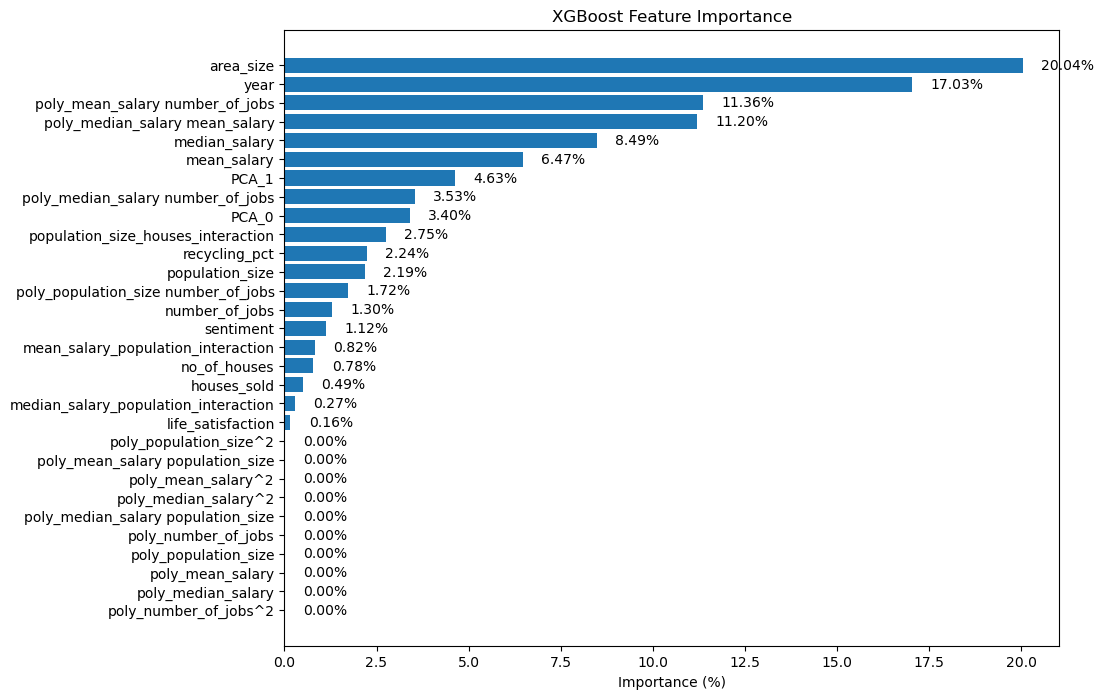

In [61]:
# Extract feature importance from the XGBoost model
xgb_importances = best_xgb.feature_importances_

# Convert to percentages
xgb_importances_pct = 100.0 * (xgb_importances / xgb_importances.sum())

# Create a DataFrame for better visualization
xgb_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_importances_pct
}).sort_values(by='Importance', ascending=False)

# Plot the feature importance for XGBoost with percentages
plt.figure(figsize=(10, 8))
bars = plt.barh(xgb_importance_df['Feature'], xgb_importance_df['Importance'])
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance (%)')
plt.gca().invert_yaxis()

# Annotate bars with the importance percentages
for bar in bars:
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2, f'{bar.get_width():.2f}%', va='center')

plt.show()

### XGBoost Feature Importance
We extract the feature importances from the tuned XGBoost model and visualize them using a horizontal bar plot. The features are sorted by their importance to make it easy to identify the most significant ones.


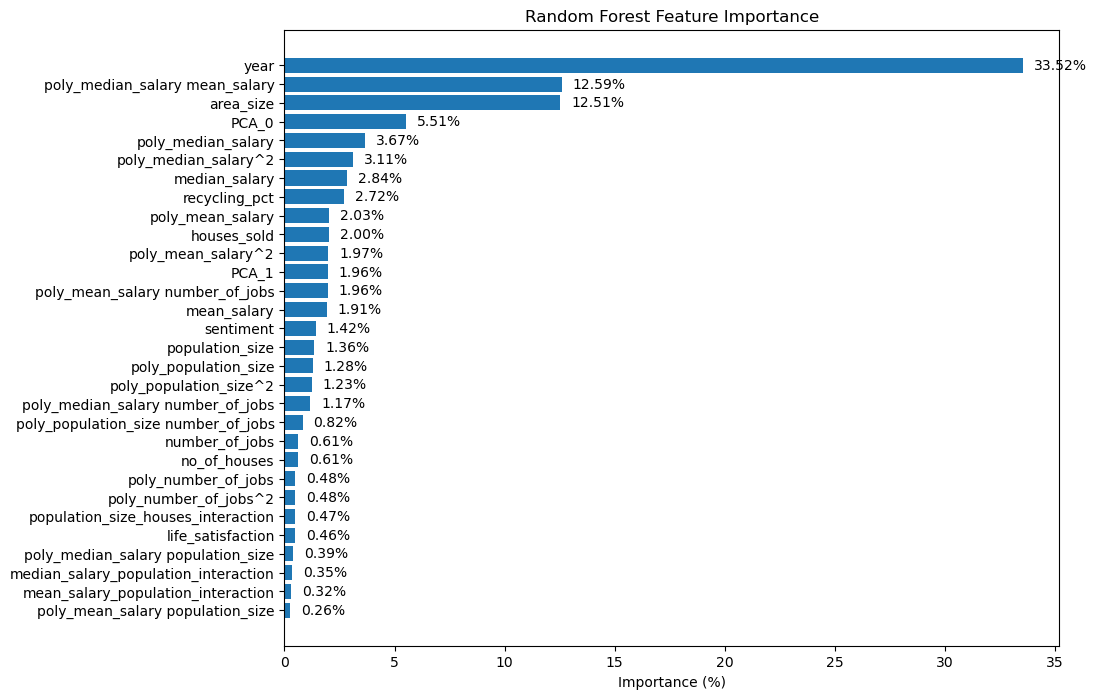

In [62]:
# Extract feature importance from the Random Forest model
rf_importances = best_rf.feature_importances_

# Convert to percentages
rf_importances_pct = 100.0 * (rf_importances / rf_importances.sum())

# Create a DataFrame for better visualization
rf_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_importances_pct
}).sort_values(by='Importance', ascending=False)

# Plot the feature importance for Random Forest with percentages
plt.figure(figsize=(10, 8))
bars = plt.barh(rf_importance_df['Feature'], rf_importance_df['Importance'])
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance (%)')
plt.gca().invert_yaxis()

# Annotate bars with the importance percentages
for bar in bars:
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2, f'{bar.get_width():.2f}%', va='center')

plt.show()

### Random Forest Feature Importance
We extract the feature importances from the tuned Random Forest model and visualize them using a horizontal bar plot. This helps to identify the features that have the most impact on the model's predictions.


In [63]:
# Import necessary libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Importing Necessary Libraries
We import Matplotlib and Seaborn for visualization and NumPy for numerical operations.


In [64]:
# Predict on the test set using the stacking ensemble with the sentiment feature
y_pred_stack_with_sentiment_test = stacking_ensemble.predict(X_test)

### Predicting Values with the Sentiment Feature
We use the stacking ensemble model (trained with the sentiment feature) to predict values on the test set.


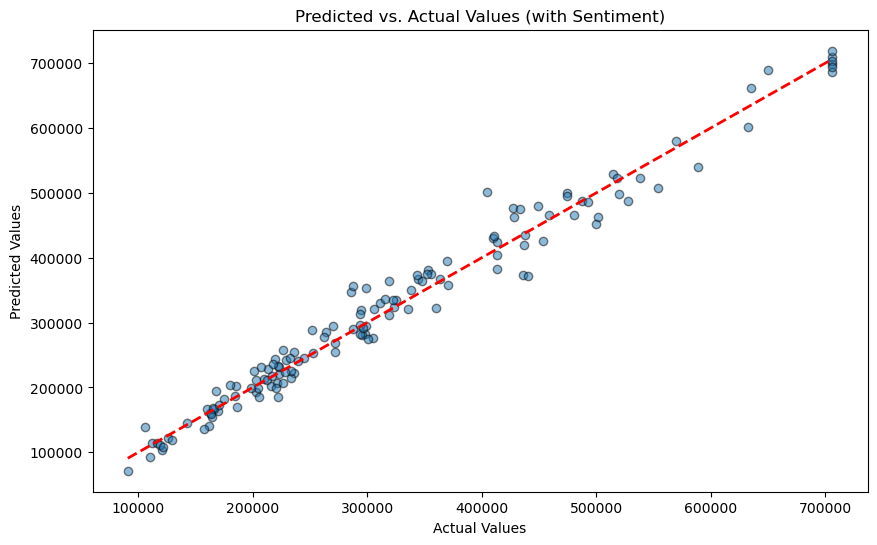

In [65]:
# Plot predicted vs. actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_stack_with_sentiment_test, alpha=0.5, edgecolors='k')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2)
plt.title('Predicted vs. Actual Values (with Sentiment)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

### Predicted vs. Actual Values Plot
This plot visualizes the relationship between the predicted values and the actual values. The closer the points are to the diagonal red line, the better the model's predictions.


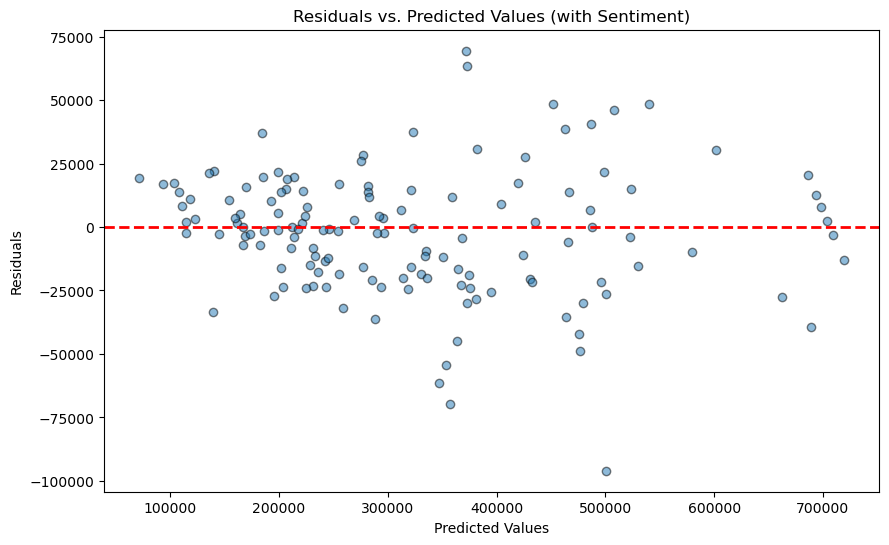

In [66]:
# Calculate residuals
residuals = y_test - y_pred_stack_with_sentiment_test

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_stack_with_sentiment_test, residuals, alpha=0.5, edgecolors='k')
plt.axhline(0, color='r', linestyle='--', lw=2)
plt.title('Residuals vs. Predicted Values (with Sentiment)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

### Residuals Plot
This plot shows the residuals (errors) plotted against the predicted values. Ideally, residuals should be randomly distributed around zero, indicating no systematic error in the model's predictions.


## XGBoost and Stacking Models Without Sentiment Feature
In this section, we train and evaluate XGBoost and stacking ensemble models on a dataset without the sentiment feature.


In [67]:
# Import necessary libraries
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pandas as pd

### Importing Necessary Libraries
We import Scikit-learn and XGBoost libraries to train and evaluate the models. Pandas and NumPy are used for data manipulation and numerical operations.


In [68]:
# Remove the sentiment feature from the training, validation, and test sets
X_train_no_sentiment = X_train.drop(columns=['sentiment'])
X_val_no_sentiment = X_val.drop(columns=['sentiment'])
X_test_no_sentiment = X_test.drop(columns=['sentiment'])

### Preparing the Dataset Without the Sentiment Feature
We remove the sentiment feature from the training, validation, and test datasets to evaluate how the models perform without this information.


In [69]:
# Initialize the XGBoost model with the best parameters found previously
best_xgb_no_sentiment = XGBRegressor(**best_xgb.get_params())

# Train the XGBoost model on the dataset without the sentiment feature
best_xgb_no_sentiment.fit(X_train_no_sentiment, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

### Training the XGBoost Model Without Sentiment
We re-train the XGBoost model on the dataset after removing the sentiment feature, using the best parameters identified earlier.


In [70]:
# Define the base models (XGBoost and Random Forest)
base_models_no_sentiment = [
    ('xgb', best_xgb_no_sentiment),
    ('rf', best_rf)  # Assuming best_rf is already trained or initialized without sentiment
]

# Define the meta-model (Linear Regression)
meta_model_no_sentiment = LinearRegression()

# Create the stacking regressor without sentiment
stacking_ensemble_no_sentiment = StackingRegressor(
    estimators=base_models_no_sentiment,
    final_estimator=meta_model_no_sentiment,
    cv=5,
    n_jobs=-1
)

# Train the stacking ensemble on the dataset without the sentiment feature
stacking_ensemble_no_sentiment.fit(X_train_no_sentiment, y_train)

StackingRegressor(cv=5,
                  estimators=[('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learni...
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=3,
                                            max_leaves=None, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=400, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                              ('rf',
                               RandomForestRegressor(max_depth=20,
                                                     n_estimators=300,
                                                     random_state=42))],
                  final_estimator=LinearRegression(), n_jobs=-1)

### Training the Stacking Ensemble Without Sentiment
We create and train the stacking ensemble model, combining XGBoost and Random Forest, on the dataset without the sentiment feature.


In [71]:
# Predict on the test set using the XGBoost model without sentiment
y_pred_xgb_no_sentiment_test = best_xgb_no_sentiment.predict(X_test_no_sentiment)

# Predict on the test set using the stacking ensemble without sentiment
y_pred_stack_no_sentiment_test = stacking_ensemble_no_sentiment.predict(X_test_no_sentiment)

# Calculate performance metrics for XGBoost without sentiment
mae_xgb_no_sentiment_test = mean_absolute_error(y_test, y_pred_xgb_no_sentiment_test)
mse_xgb_no_sentiment_test = mean_squared_error(y_test, y_pred_xgb_no_sentiment_test)
rmse_xgb_no_sentiment_test = np.sqrt(mse_xgb_no_sentiment_test)
r2_xgb_no_sentiment_test = r2_score(y_test, y_pred_xgb_no_sentiment_test)

# Calculate performance metrics for stacking ensemble without sentiment
mae_stack_no_sentiment_test = mean_absolute_error(y_test, y_pred_stack_no_sentiment_test)
mse_stack_no_sentiment_test = mean_squared_error(y_test, y_pred_stack_no_sentiment_test)
rmse_stack_no_sentiment_test = np.sqrt(mse_stack_no_sentiment_test)
r2_stack_no_sentiment_test = r2_score(y_test, y_pred_stack_no_sentiment_test)

# Compile the results into a dictionary
test_results_no_sentiment = {
    'XGBoost without Sentiment': {
        'MAE': mae_xgb_no_sentiment_test,
        'MSE': mse_xgb_no_sentiment_test,
        'RMSE': rmse_xgb_no_sentiment_test,
        'R-squared': r2_xgb_no_sentiment_test
    },
    'Stacking Ensemble without Sentiment': {
        'MAE': mae_stack_no_sentiment_test,
        'MSE': mse_stack_no_sentiment_test,
        'RMSE': rmse_stack_no_sentiment_test,
        'R-squared': r2_stack_no_sentiment_test
    }
}

# Convert the results into a DataFrame for easy comparison
test_results_no_sentiment_df = pd.DataFrame(test_results_no_sentiment).T

# Convert MSE columns to integer type
test_results_no_sentiment_df['MSE'] = test_results_no_sentiment_df['MSE'].astype(int)
test_results_no_sentiment_df['MSE'] = test_results_no_sentiment_df['MSE'].astype(int)

# Display the results for both models on the test set without sentiment
test_results_no_sentiment_df

,MAE,MSE,RMSE,R-squared
XGBoost without Sentiment,20150.194091,750527106,27395.749792,0.967033
Stacking Ensemble without Sentiment,20426.638285,736611770,27140.592665,0.967645


### Evaluating the Models on the Test Set Without Sentiment
We evaluate the performance of both the XGBoost model and the stacking ensemble on the test set after removing the sentiment feature. The results are presented in a DataFrame for easy comparison.
